In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import healpy as hp
import numpy as np
import tensorflow as tf

from deepsphere import HealpyGCNN
from deepsphere import healpy_layers as hp_layer
from deepsphere import utils

from tqdm import tqdm

In [2]:
import os

In [3]:
# import pyccl as ccl

# cosmo = ccl.Cosmology(Omega_c = 0.262, Omega_b = 0.048, h = 0.69, sigma8 = 0.83, n_s = 0.96)

# zs=np.linspace(0,1,100)
# dNdz = np.ones(zs.shape)
# bias = 1*np.ones(len(dNdz))

# clustering = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(zs,dNdz), bias=(zs,bias))
# ell = np.arange(0,6144)
# cls_clu = ccl.angular_cl(cosmo, clustering, clustering, ell) #Clustering

In [4]:
# kSZMap = hp.read_map("./kSZ_NS_2048_R_2048_P_2560_DV_256.fits")

In [5]:
# kSZPowSpec = hp.anafast(kSZMap)

In [6]:
kSZFiles = os.listdir('./Data/kSZ')
velFiles = os.listdir('./Data/velocityField')
densFiles = os.listdir('./Data/overdensity')

nside = 64
numSets=len(densFiles)

In [7]:
overdensData = np.zeros((numSets,12*nside**2))
kSZData = np.zeros((numSets,12*nside**2))
velData = np.zeros((numSets,12*nside**2))

In [8]:
for i in range(0,numSets):
    overdensData[i] = hp.reorder(np.load('./Data/overdensity/'+densFiles[i]),r2n=True)
    overdensData[i] = overdensData[i]/np.linalg.norm(overdensData[i])
    kSZData[i] = hp.reorder(np.load('./Data/kSZ/'+kSZFiles[i]),r2n=True)
    kSZData[i] = kSZData[i]/np.linalg.norm(kSZData[i])
    velData[i] = hp.reorder(np.load('./Data/velocityField/'+velFiles[i]),r2n=True)
    velData[i] = velData[i]/np.linalg.norm(velData[i])
# for i in range(0,numSets):
#     overdensData[i] = hp.reorder(hp.synfast(cls_clu,nside=nside),r2n=True)
#     kSZData[i] = hp.reorder(100000*hp.synfast(kSZPowSpec,nside=nside),r2n=True)
#     velData[i] = hp.reorder(kSZData[i]/(overdensData[i]+1),r2n=True)

In [9]:
x_raw = np.stack((overdensData,kSZData),axis=2)
x_raw = np.reshape(x_raw,(numSets,12*nside**2,2))

x_train, x_test = np.split(x_raw, indices_or_sections=[numSets-85])
y_train, y_test = np.split(velData, indices_or_sections=[numSets-85])

In [10]:
dset_test = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(x_test),
                                 tf.data.Dataset.from_tensor_slices(y_test)))
dset_test = dset_test.shuffle(20)
dset_test = dset_test.batch(10)

dset_train = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(x_train),
                                  tf.data.Dataset.from_tensor_slices(y_train)))
dset_train = dset_train.shuffle(200)
dset_train = dset_train.batch(10)

In [11]:
AUTOTUNE = tf.data.AUTOTUNE

dset_train = dset_train.prefetch(buffer_size=AUTOTUNE)
dset_test = dset_test.prefetch(buffer_size=AUTOTUNE)

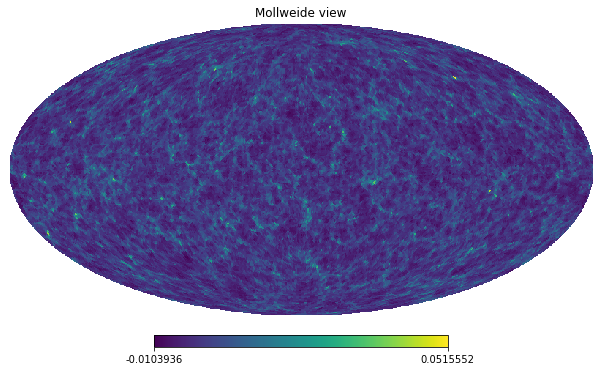

In [12]:
hp.mollview(overdensData[350]/np.linalg.norm(overdensData[350]),nest=True)

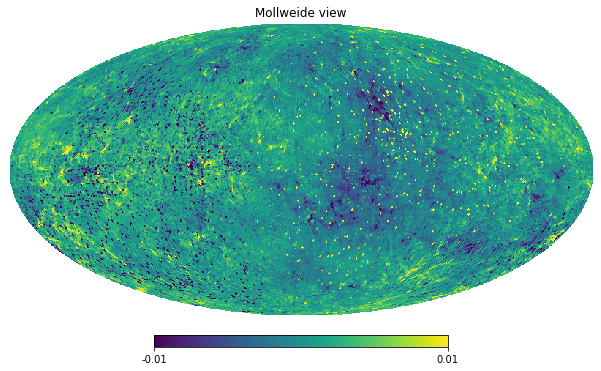

In [13]:
hp.mollview(kSZData[350]/np.linalg.norm(kSZData[350]),nest=True,max=.01,min=-0.01)

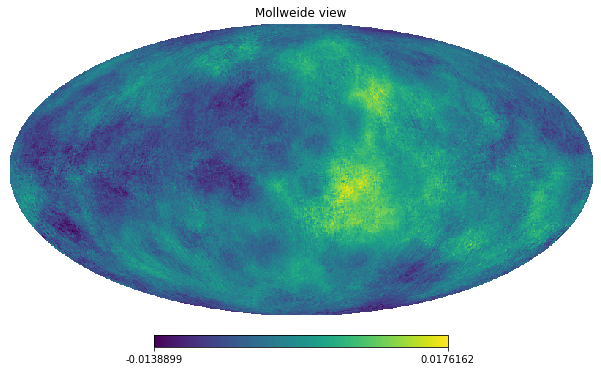

In [14]:
hp.mollview(velData[350]/np.linalg.norm(velData[350]),nest=True)

In [15]:
def r_square(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [21]:
K = 5
layers = [#hp_layer.HealpyPseudoConv_Transpose(p=1, Fout=64, activation="linear"),
                  hp_layer.HealpyChebyshev(K=K, Fout=64, use_bias=True, use_bn=False, 
                                   activation="linear"),
                  hp_layer.HealpyChebyshev(K=K, Fout=32, use_bias=True, use_bn=False, 
                                   activation="linear"),
                  #hp_layer.HealpyPseudoConv(p=1, Fout=32, activation="linear"),
                  #hp_layer.HealpyPseudoConv(p=1, Fout=16, activation="elu"),
                  #hp_layer.HealpyPseudoConv(p=1, Fout=32, activation="elu"),
                  hp_layer.HealpyChebyshev(K=K, Fout=32, use_bias=True, use_bn=False, 
                                   activation="linear"),
                  tf.keras.layers.LayerNormalization(axis=1),
                  #hp_layer.HealpyPseudoConv(p=1, Fout=32, activation="linear"),
                  hp_layer.HealpyMonomial(K=K, Fout=32, use_bias=True, use_bn=False, 
                                           activation="linear"),
                  hp_layer.HealpyPseudoConv(p=1, Fout=32, activation="linear"),
                  #tf.keras.layers.BatchNormalization(),
                  hp_layer.HealpyChebyshev(K=K, Fout=32, use_bias=True, use_bn=False, 
                                   activation="linear"),
                  hp_layer.HealpyChebyshev(K=K, Fout=32, use_bias=True, use_bn=False, 
                                   activation="linear"),
                  #tf.keras.layers.LayerNormalization(axis=1),
                  hp_layer.HealpyChebyshev(K=K, Fout=32, use_bias=True, use_bn=False, 
                                           activation="linear"),
                  tf.keras.layers.LayerNormalization(axis=1),
                  #hp_layer.HealpyPool(p=1,pool_type='MAX'),
                  hp_layer.HealpyMonomial(K=K, Fout=32, use_bias=True, use_bn=False, 
                                           activation="linear"),
                  hp_layer.HealpyPseudoConv_Transpose(p=1, Fout=32, activation="linear"),
                  #tf.keras.layers.LayerNormalization(axis=1),
                  #hp_layer.HealpyPseudoConv_Transpose(p=1, Fout=16, activation="elu"),
                  #hp_layer.HealpyPseudoConv_Transpose(p=1, Fout=16, activation="elu"),
                  hp_layer.HealpyChebyshev(K=K, Fout=32, use_bias=True, use_bn=False, 
                                   activation="linear"),
                  #tf.keras.layers.Dense(12*nside**2)
                  #hp_layer.HealpyPseudoConv_Transpose(p=1, Fout=24, activation="linear"),
                  hp_layer.HealpyChebyshev(K=K, Fout=24, use_bias=True, use_bn=False, 
                                   activation="linear"),
                  hp_layer.HealpyChebyshev(K=K, Fout=24, use_bias=True, use_bn=False, 
                                   activation="linear"),
                  hp_layer.HealpyChebyshev(K=K, Fout=16, use_bias=True, use_bn=False, 
                                           activation="linear"),
                  hp_layer.HealpyChebyshev(K=K, Fout=8, use_bias=True, use_bn=False, 
                                   activation="linear"),
                  hp_layer.HealpyChebyshev(K=K, Fout=1, use_bias=True, use_bn=False, 
                                   activation="linear")
         ]

K2=5

LayersTest = [    hp_layer.HealpyChebyshev(K=K2, Fout=16, use_bias=True, use_bn=False, 
                                   activation="linear"),
                  hp_layer.HealpyChebyshev(K=K2, Fout=16, use_bias=True, use_bn=False, 
                                   activation="linear"),
                  hp_layer.HealpyChebyshev(K=K2, Fout=16, use_bias=True, use_bn=False, 
                                   activation="linear"),
                  hp_layer.HealpyChebyshev(K=K2, Fout=16, use_bias=True, use_bn=False, 
                                   activation="linear"),
                  hp_layer.HealpyChebyshev(K=K2, Fout=16, use_bias=True, use_bn=False, 
                                   activation="linear"),
                  hp_layer.HealpyChebyshev(K=K2, Fout=16, use_bias=True, use_bn=False, 
                                   activation="linear"),
                  hp_layer.HealpyChebyshev(K=K2, Fout=16, use_bias=True, use_bn=False, 
                                   activation="linear"),
                  hp_layer.HealpyChebyshev(K=K2, Fout=8, use_bias=True, use_bn=False, 
                                   activation="linear"),
                  hp_layer.HealpyChebyshev(K=K2, Fout=4, use_bias=True, use_bn=False, 
                                   activation="linear"),
                  hp_layer.HealpyChebyshev(K=K2, Fout=1, use_bias=True, use_bn=False, 
                                   activation="linear"),
                  
         ]

In [22]:
#help(hp_layer.HealpyPool)

In [23]:
n_pix = hp.nside2npix(nside)
indices = np.arange(n_pix)
modelHP = HealpyGCNN(nside=nside, layers=layers,indices=np.arange(0,12*nside**2), n_neighbors=40)
modelHP.build(input_shape=(None, len(indices), 2))
modelHP.summary(110)

Detected a reduction factor of 1.0, the input with nside 64 will be transformed to 64 during a forward pass. Checking for consistency with indices...
indices seem consistent...
Model: "healpy_gcnn_3"
______________________________________________________________________________________________________________
 Layer (type)                                    Output Shape                                Param #          
 chebyshev_12 (Chebyshev)                        (None, 49152, 64)                           704              
                                                                                                              
 chebyshev_13 (Chebyshev)                        (None, 49152, 32)                           10272            
                                                                                                              
 chebyshev_14 (Chebyshev)                        (None, 49152, 32)                           5152             
                       

In [24]:
modelHP.compile(optimizer=tf.keras.optimizers.Adam(1e-2),
              #loss=tf.keras.losses.Huber(delta=1.0,reduction="auto",name="huber_loss"),
                loss="MSE",
              metrics=[r_square]
)

In [25]:
history = modelHP.fit(
    dset_train,
    epochs=10,
    validation_data = dset_test
)

Epoch 1/10
140/140 [==============================] - 186s 1s/step - loss: 0.9850 - r_square: -49789.6641 - val_loss: 1.3993e-04 - val_r_square: -6.0299
Epoch 2/10
140/140 [==============================] - 184s 1s/step - loss: 1.0603e-04 - r_square: -4.3285 - val_loss: 8.7741e-05 - val_r_square: -3.4668
Epoch 3/10
140/140 [==============================] - 184s 1s/step - loss: 7.5120e-05 - r_square: -2.7743 - val_loss: 6.7809e-05 - val_r_square: -2.4112
Epoch 4/10
140/140 [==============================] - 184s 1s/step - loss: 6.0403e-05 - r_square: -2.0212 - val_loss: 5.6096e-05 - val_r_square: -1.7989
Epoch 5/10
140/140 [==============================] - 184s 1s/step - loss: 5.0710e-05 - r_square: -1.5399 - val_loss: 4.7666e-05 - val_r_square: -1.3874
Epoch 6/10
140/140 [==============================] - 184s 1s/step - loss: 4.3793e-05 - r_square: -1.1985 - val_loss: 4.1564e-05 - val_r_square: -1.1335
Epoch 7/10
140/140 [==============================] - 184s 1s/step - loss: 3.8570e

In [26]:
initial_epochs = 10
fine_tune_epochs = 2
total_epochs =  initial_epochs + fine_tune_epochs

history_further = modelHP.fit(dset_train,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=dset_test)

Epoch 10/12
140/140 [==============================] - 184s 1s/step - loss: 2.6835e-05 - r_square: -0.3451 - val_loss: 2.7939e-05 - val_r_square: -0.3867
Epoch 11/12
140/140 [==============================] - 184s 1s/step - loss: 2.5177e-05 - r_square: -0.2621 - val_loss: 2.5280e-05 - val_r_square: -0.2942
Epoch 12/12
140/140 [==============================] - 184s 1s/step - loss: 2.3544e-05 - r_square: -0.1787 - val_loss: 2.2834e-05 - val_r_square: -0.1546


In [27]:
total_epochs =  initial_epochs + fine_tune_epochs+2

history_furthest = modelHP.fit(dset_train,
                         epochs=total_epochs,
                         initial_epoch=history_further.epoch[-1],
                         validation_data=dset_test)

Epoch 12/14
140/140 [==============================] - 184s 1s/step - loss: 2.2331e-05 - r_square: -0.1176 - val_loss: 2.1843e-05 - val_r_square: -0.0970
Epoch 13/14
140/140 [==============================] - 184s 1s/step - loss: 2.1633e-05 - r_square: -0.0848 - val_loss: 2.2666e-05 - val_r_square: -0.1580
Epoch 14/14
140/140 [==============================] - 184s 1s/step - loss: 2.1327e-05 - r_square: -0.0704 - val_loss: 2.2598e-05 - val_r_square: -0.1546


In [28]:
total_epochs =  initial_epochs + fine_tune_epochs+2+2

history_furthester = modelHP.fit(dset_train,
                         epochs=total_epochs,
                         initial_epoch=history_furthest.epoch[-1],
                         validation_data=dset_test)

Epoch 14/16
140/140 [==============================] - 184s 1s/step - loss: 2.1169e-05 - r_square: -0.0602 - val_loss: 2.0111e-05 - val_r_square: -0.0066
Epoch 15/16
140/140 [==============================] - 184s 1s/step - loss: 1.9218e-05 - r_square: 0.0382 - val_loss: 1.9287e-05 - val_r_square: 0.0283
Epoch 16/16
140/140 [==============================] - 184s 1s/step - loss: 1.8540e-05 - r_square: 0.0696 - val_loss: 1.7969e-05 - val_r_square: 0.0859


In [29]:
reconst = np.reshape(modelHP(x_train[:1],True).numpy(),(12*nside**2))
goal = np.reshape(y_train[:1],(12*nside**2))

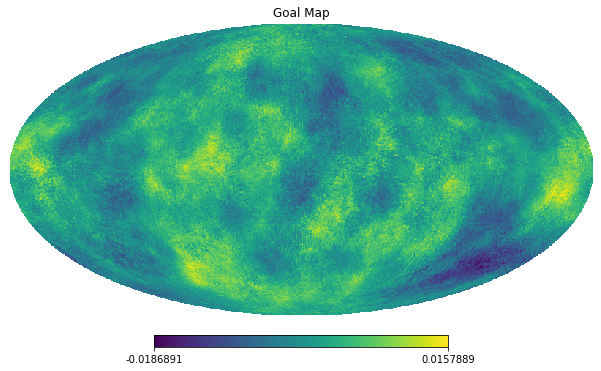

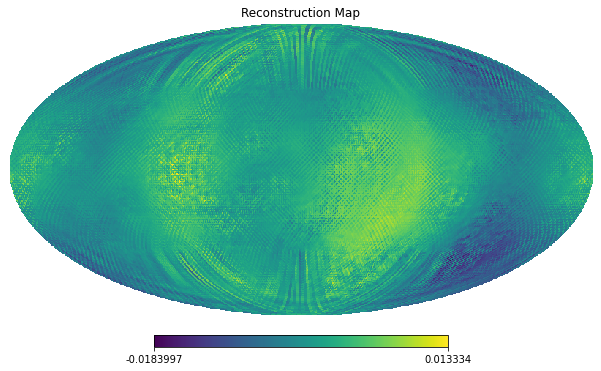

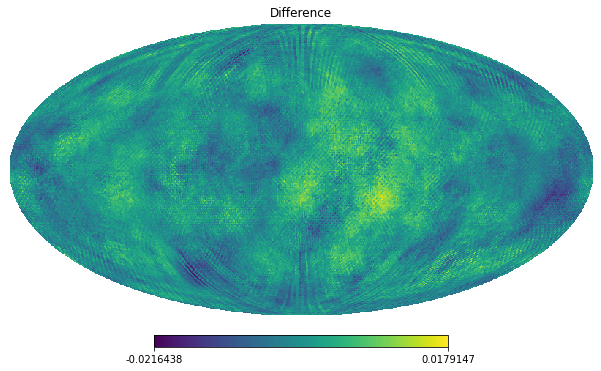

In [30]:
hp.mollview(goal, nest=True, title="Goal Map");
hp.mollview(reconst, nest=True, title="Reconstruction Map");
hp.mollview(reconst - goal, nest=True, title="Difference");

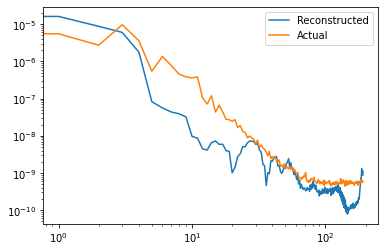

In [31]:
reconst = hp.reorder(reconst,n2r=True)
goal = hp.reorder(goal,n2r=True)
plt.loglog(hp.anafast(reconst))
plt.loglog(hp.anafast(goal))
plt.legend(["Reconstructed","Actual"])

In [32]:
correlation = hp.anafast(reconst,goal)/np.sqrt(hp.anafast(goal)*hp.anafast(reconst)) 

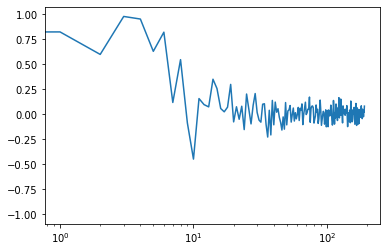

In [33]:
plt.semilogx(correlation);

In [34]:
np.mean(correlation)

0.03084341059199582

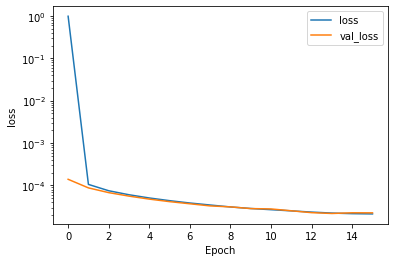

In [42]:
plt.semilogy(np.concatenate((history.history['loss'],history_further.history['loss'],history_furthest.history['loss'])), label='loss');
plt.semilogy(np.concatenate((history.history['val_loss'],history_further.history['val_loss'],history_furthest.history['val_loss'])), label = 'val_loss');
plt.xlabel('Epoch')
plt.ylabel('loss')
#plt.ylim([0.5, 1])
plt.legend(loc='upper right');

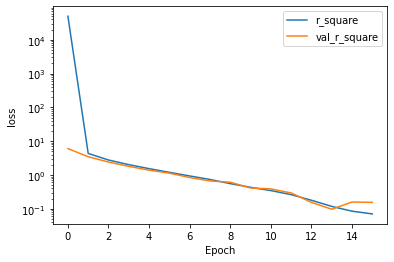

In [43]:
plt.semilogy(-np.append(np.append(history.history['r_square'],history_further.history['r_square']),history_furthest.history['r_square']), label='r_square')
plt.semilogy(-np.append(np.append(history.history['val_r_square'],history_further.history['val_r_square']),history_furthest.history['val_r_square']), label = 'val_r_square')
plt.xlabel('Epoch')
plt.ylabel('loss')
#plt.ylim([0.5, 1])
plt.legend(loc='upper right')